# Predicting the Geographical Origin of Music

## Overview

The quesion that we are looking at, is weather the geographical origin of songs can be predicted based on different audio features. The data can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/geographical+original+of+music). Prior exploration has been performed on this data. The most well-known study can be viewed [here](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7023456).

## Data Exploaration

The dataset consists of audio features that were extracted using [MARSYAS](http://marsyasweb.appspot.com/). The features that we are using can be seen as the key audio features of a song. We need to predict the geographical region of a song based on these features. The data does not include geographical regions, but rather lattitudanal and longitudinal coordinates. We would need to first perform clustering to figure out the geographical region for a set of coordinates.

## Data Preparation

In [1]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))

In [2]:
data = np.asarray(data)
data.shape

(1059, 70)

Each row is a song (observation) and each song is an audio feature. However, the last two columns are the geographical coordinates, so we need to split this appropriately.

In [3]:
X = data[:, 0:68]
y = data[:, 68:70]

print("X sample")
print(X[0, 1])
print("")
print("y sample")
print(y[0, 0:2])

X sample
7.835325

y sample
['-15.75' '-47.95']


Unfortunately, the coordinates are character values. We need to convert these to numerical values to see the relationship between them on a map.

In [4]:
y = y.astype(dtype = np.float)
print(y[0, 0:2])

[-15.75 -47.95]


Seeing that we need to predict the geographic area, we need to reduce the two coordinate prediction column to a single prediction column. Dimension reduction techniques such as PCA might work, but seeing that we know that there are 33 geographic locations within the data, clustering might be a better approach.

In [5]:
n_clusters = 33
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, algorithm='full')
kmeans = kmeans.fit(y)
labels = kmeans.predict(y)

#print('Centroids')
centroids = kmeans.cluster_centers_
#print(centroids)

<Figure size 432x288 with 0 Axes>

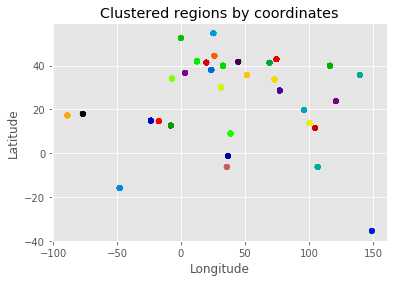

<Figure size 432x288 with 0 Axes>

In [6]:
plt.style.use('ggplot')
label_color = [matplotlib.cm.nipy_spectral(float(l) /n_clusters) for l in labels]
plt.scatter(y[:, 1], y[:, 0], c = label_color, s=25)
plt.title("Clustered regions by coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()

According to the research paper, data was collected from 33 countries/regions. As we can see from the plot above, it seems as if the coordinates provided are identical per region. However, it seeems as if some of the geographical regions are closer to each other than others. Even though countries or regions might be divided by borders, it seems logical that some of these geographical regions would be influenced by nearby located regions. This is important to bear in mind. If we are making inaccurate classifications, we might want to see whether the prediction is a nearby region. If this is the case, we should consider reducing the number of clusters.

In [7]:
y = labels

Since we do not know exactly what each feature means and what the range is of each feature, it would be a good idea to scale the X data. This will prevent estimators that are influenced by the dimensionality of the feature space to be influenced too much by variables that have wider ranges than others.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8, random_state=1234)

X_scaler = StandardScaler().fit(X)


scaled_Xtrain = X_scaler.transform(Xtrain)
scaler = StandardScaler()
scaled_Xtest = X_scaler.transform(Xtest)

# scaler = StandardScaler()
# scaler.fit(Xtrain)

# Xtrain = scaler.transform(Xtrain)
# Xtest = scaler.transform(Xtest)


/home/nikhil/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype <U9 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  Deprec

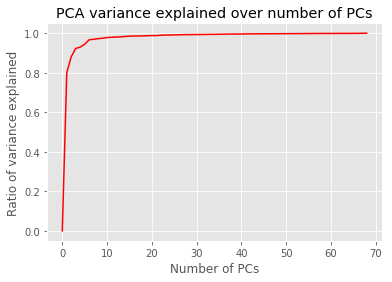

In [10]:
#for n_comps in range(0, X_scaler.shape[1], 1):
PCA_var = PCA(n_components = X_scaler.transform(X).shape[1])
PCA_var.fit(X_scaler.transform(X))
PCA_var_exp = [1 - x/sum(PCA_var.explained_variance_) for x in PCA_var.explained_variance_]

PCA_var_exp.insert(0, 0)

plt.figure()
plt.title("PCA variance explained over number of PCs")
plt.xlabel("Number of PCs")
plt.ylabel("Ratio of variance explained")
plt.plot(range(0, len(PCA_var_exp), 1), PCA_var_exp, c = 'r')
plt.show()

## Feature selection

We have 68 features, but we have no idea whether all the features are relevant or not.

We can use Python's `RFE` function to perform backward selection and the `PCA` function to reduce dimensionality by minimising the lost variance.

With `PCA` we can determine the amount of variance lost as the dimensions are reduced, but for `RFE` we need an estimator to determine whether omitting a feature will result in a decrease in accuracy score or not. To keep our measurement metrics consistent, we will rather test the reduced dimensionalty of `PCA` in terms of accuracy when using different estimators.

For this reason, we need an estimator to validate the feature selection. We can test `RFE` and `PCA` with a variety of estimators and compare the different feature selection results between the models.

However, because we do not yet know which features to use, it is difficult to know what our hyperparameter values should be for our models. To make sure that we aren't making any assumptions in terms of which hyperparameters work best, we will apply grid search for each feature selection iteration. We can then use the best accuracy obtained for a specific number of features for each estimator.

The problem on hand is a classification problem, which limits the type of estimators we can use. We will be considering the following estimators - random forest, SVM (SVC) with a linear kernel and Logistic Regression. K-nearestneighbours is another possible estimator, but because it does not perform well in high dimensionality, it will not be included during the feature selection process.

Each estimator that is being used, is being trained on training data, and validated using an independent data subset.

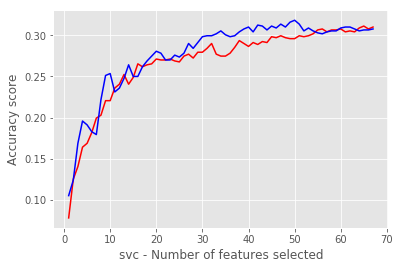

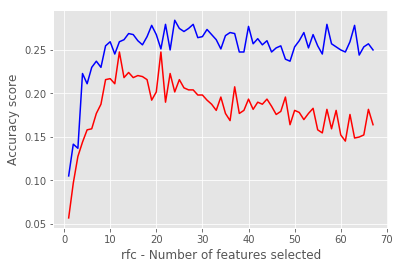

KeyboardInterrupt: 

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression



#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8, random_state=1234)

estimators = {}

estimators['svc'] = SVC
estimators['rfc'] = RandomForestClassifier
estimators['logreg'] = LogisticRegression

params = {}
params['svc'] = {'kernel': ['linear'], 'C': [10**x for x in range(-1, 3, 1)], 
                 'gamma': [10**x for x in range(-1, 2, 1)], 
                'random_state': [1234]}
params['rfc'] = {'n_estimators': [5*x for x in range(3, 5, 1)]}

params['logreg'] = {'C': [10**x for x in range(-1, 3, 1)], 'penalty': ['l1', 'l2']}

rfe_best_model = {}
pca_best_model = {}
                          

for i, estimator in enumerate(estimators):
    model_params = ParameterGrid(params[estimator])
    grid = model_params
    
    rfe_best_model[estimator] = []
    pca_best_model[estimator] = []
    
    for n_comps in range(1, scaled_Xtrain.shape[1], 1):
        rfe_best_model[estimator].append(0)
        pca_best_model[estimator].append(0)
            
        for params_combo in grid:
        
            estimator_iter = estimators[estimator]
            estimator_iter = estimator_iter(**params_combo)

            rfe = RFE(estimator = estimator_iter, n_features_to_select=n_comps)
            rfe.fit(scaled_Xtrain, ytrain)

            if (rfe.score(scaled_Xtest, ytest) > rfe_best_model[estimator][n_comps - 1]):
                rfe_best_model[estimator][n_comps - 1] = rfe.score(scaled_Xtest, ytest)
                
            PCA_model = PCA(n_components = n_comps)
            PCA_model.fit(scaled_Xtrain)
            PCA_Xtrain = PCA_model.transform(scaled_Xtrain)
            PCA_Xtest = PCA_model.transform(scaled_Xtest)
            
            estimator_iter.fit(PCA_Xtrain, ytrain)
            
            if (estimator_iter.score(PCA_Xtest, ytest) > pca_best_model[estimator][n_comps - 1]):
                pca_best_model[estimator][n_comps - 1] = estimator_iter.score(PCA_Xtest, ytest)

    plt.figure()
    plt.xlabel("%s - Number of features selected" % estimator)
    plt.ylabel("Accuracy score")
    plt.plot(range(1, len(pca_best_model[estimator]) + 1, 1), pca_best_model[estimator], c = 'r')
    plt.plot(range(1, len(rfe_best_model[estimator]) + 1, 1), rfe_best_model[estimator], c = 'b')
    plt.show()

The red lines represent the PCA dimension reduction and the blue lines represent RFE for the different estimators used.

It would seem as if backward selection (RFE) is giving us higher accuracy scores than PCA in general. All the plots seem to level out around models containing 10 features. For this reason, we will select the 10 best features according to backward selection and build our model on this. The additional features are not adding a lot of value.

In [12]:
rfe_best_model_2 = {}
pca_best_model_2 = {}

rfe_best_model_2['svc'] = []
rfe_best_model_2['rfc'] = []
rfe_best_model_2['logreg'] = []

accuracies = {}

accuracies['svc'] = [0]
accuracies['rfc'] = [0]

accuracies['logreg'] = [0]

features = {}

features['svc'] = []
features['rfc'] = []
features['logreg'] = []

estimator_list = []

n_comps = 20
                          
for i, estimator in enumerate(estimators):
    
    estimator_list.append(estimator)
    model_params = ParameterGrid(params[estimator])
    grid = model_params
    
    rfe_best_model_2[estimator] = []
    
    rfe_best_model_2[estimator].append(0)
    #pca_best_model_2[estimator].append(0)

    for params_combo in grid:
        estimator_iter = estimators[estimator]
        estimator_iter = estimator_iter(**params_combo)

        rfe = RFE(estimator = estimator_iter, n_features_to_select=n_comps)
        rfe.fit(scaled_Xtrain, ytrain)

        if (rfe.score(scaled_Xtest, ytest) > accuracies[estimator][0]):
            accuracies[estimator][0] = [rfe.score(scaled_Xtest, ytest)]
            features[estimator] = rfe.support_


In [13]:
import pandas as pd

est_columns = ['SVC','RFC','Log_Reg'] 
est_index = ['feature_%d'%i for i in range(0,len(features['svc']))]

# display format as scientific 
pd.options.display.float_format = '{:,.4g}'.format
est_df = pd.DataFrame(index=est_index, columns=est_columns)
est_df

for i in range(0, len(features['svc'])):
    est_df.iloc[i, 0] = features['svc'][i]
    est_df.iloc[i, 1] = features['rfc'][i]
    est_df.iloc[i, 2] = features['logreg'][i]
    
print('Features used by any Estimator')
est_df[est_df['SVC'] | est_df['RFC'] | est_df['Log_Reg']]

Features used by any Estimator


,SVC,RFC,Log_Reg
feature_4,True,True,True
feature_6,True,False,True
feature_7,True,True,True
feature_8,True,True,True
feature_10,True,False,True
feature_11,False,True,True
feature_12,True,False,False
feature_14,True,False,False
feature_15,True,True,True
feature_16,False,True,False


In [14]:
print('Features used by all Estimators')
est_df[est_df['SVC'] & est_df['RFC'] & est_df['Log_Reg']]

Features used by all Estimators


,SVC,RFC,Log_Reg
feature_4,True,True,True
feature_7,True,True,True
feature_8,True,True,True
feature_15,True,True,True
feature_20,True,True,True
feature_25,True,True,True
feature_34,True,True,True
feature_35,True,True,True
feature_52,True,True,True
feature_55,True,True,True


In [15]:
from sklearn.feature_selection import RFE

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8, random_state=1234)

rfc = RandomForestClassifier(n_estimators=35)

rfe = RFE(estimator = rfc, n_features_to_select=20)
rfe.fit(Xtrain, ytrain)
X_reduced = rfe.transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced, y, test_size=0.8, random_state=1234)

In [16]:
X_reduced.shape

(1059, 20)

## Model Building

We can now use this these features to test out the same estimators and include k nearest neighbours.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

estimators = {}

estimators['svc'] = SVC
estimators['rfc'] = RandomForestClassifier
estimators['knn'] = KNeighborsClassifier
# estimators['logreg'] = LogisticRegression

params = {}
params['svc'] = {'kernel': ['linear'], 'C': [10**x for x in range(-2, 3, 1)], 
                 'gamma': [10**x for x in range(-2, 3, 1)], 
                'random_state': [1234]}
params['rfc'] = {'n_estimators': [5*x for x in range(1, 8, 1)]}

params['knn'] = {'n_neighbors': range(1, 15, 1), 'p': [1, 2]}
# params['logreg'] = {'C': [10**x for x in range(-1, 3, 1)], 'penalty': ['l1', 'l2']}

best_model = {}

for i, estimator in enumerate(estimators):
    model_params = ParameterGrid(params[estimator])
    grid = model_params
    
    best_model[estimator] = [0]
    
    for params_combo in grid:
        
        estimator_iter = estimators[estimator]
        estimator_iter = estimator_iter(**params_combo)
            
        estimator_iter.fit(Xtrain, ytrain)
        scores = cross_val_score(estimator_iter, Xtrain, ytrain, cv = 10, scoring='accuracy') # smallest class has 2 members
        
        if (scores.mean() > best_model[estimator][0]):
            best_model[estimator] = [scores.mean(), estimator_iter.get_params]

    print("For %s the best cv accuracy score is %s" % (estimator, best_model[estimator][0]))

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, w

For svc the best cv accuracy score is 0.33294395297684776


/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, w

For rfc the best cv accuracy score is 0.3894456201693044


/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, w

For knn the best cv accuracy score is 0.39004789070578544


/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


## Re-clustering

The cross validation scorese for the differernt models are fairly similar, but all of them are really low. Due to this reason, it might be a good idea use clustering to re-assign the the classification groups. Seeing that the initial problem relates to geographic locations, we have to apply clustering based on the coordinates of the region. It would be fair to say that the US and Australia listens to similar types of music, but then we will be predicting music types instead of regions. For now, let's group by geographic locations.

We can apply each of the models above to different number of clusters to see if our accuracy improves.

In [18]:
with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))
    
data = np.asarray(data)
data.shape

y_coords = data[:, 68:70]
y_coords = y_coords.astype(dtype = np.float)

n_clusters = range(2, 33, 1)

accuracies = {'svc':[], 'rfc':[], 'knn':[]}

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, max_iter = 300, algorithm='full')
    kmeans = kmeans.fit(y_coords)
    labels = kmeans.predict(y_coords)
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, labels, test_size=0.8, random_state=1234)

    best_model = {}

    for i, estimator in enumerate(estimators):
        model_params = ParameterGrid(params[estimator])
        grid = model_params

        best_model[estimator] = [0]
        #accuracies[estimator] = []

        for params_combo in grid:

            estimator_iter = estimators[estimator]
            estimator_iter = estimator_iter(**params_combo)

            #estimator_iter.fit(Xtrain, ytrain)
            scores = cross_val_score(estimator_iter, Xtrain, ytrain, cv = 10, scoring='accuracy') # smallest class has 2 members

            if (scores.mean() > best_model[estimator][0]):
                best_model[estimator] = [scores.mean(), estimator_iter.get_params]

        accuracies[estimator].append(best_model[estimator][0])

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, w

/home/nikhil/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

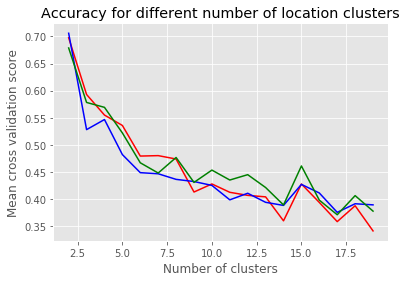

In [19]:
plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Mean cross validation score")
plt.title("Accuracy for different number of location clusters")
plt.plot(range(2, len(accuracies['knn']) + 2),accuracies['knn'], c = 'r')
plt.plot(range(2, len(accuracies['svc']) + 2),accuracies['svc'], c = 'b')
plt.plot(range(2, len(accuracies['rfc']) + 2),accuracies['rfc'], c = 'g')
plt.show()

The plot shows that the accuracy decreases exponentially as the number of coordinate clusters increase. This is understandable, becuase it is more likely of randomly predicting the correct cluster if there are only a few clusters to choose from. The elbow of the curves above is around 7 clusters. No penalty score has been added, which makes it understandable that the slopes continues to decrease after this.

Given the above plot, it would be a good idea to visualise the above three models at 5 neighbours on a coordinate scatterplot.

We can view the coordinates for 5  clusters to see if it makes sense.

<Figure size 432x288 with 0 Axes>

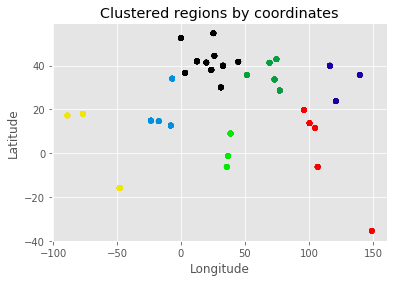

<Figure size 432x288 with 0 Axes>

In [20]:
with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))
    
data = np.asarray(data)
data.shape

y_coords = data[:, 68:70]
y_coords = y_coords.astype(dtype = np.float)

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, algorithm='full')
kmeans = kmeans.fit(y_coords)
labels = kmeans.predict(y_coords)

#print('Centroids')
centroids = kmeans.cluster_centers_
#print(centroids)

plt.style.use('ggplot')
label_color = [matplotlib.cm.nipy_spectral(float(l) /n_clusters) for l in labels]
plt.scatter(y_coords[:, 1], y_coords[:, 0], c = label_color, s=25)
plt.title("Clustered regions by coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()

In [21]:
best_model

{'svc': [0]}

In [24]:
with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))
    
data = np.asarray(data)
data.shape

y_coords = data[:, 68:70]
y_coords = y_coords.astype(dtype = np.float)

n_clusters = 7

accuracies = {'svc':[], 'rfc':[], 'knn':[]}

kmeans = KMeans(n_clusters=n_clusters, max_iter = 300, algorithm='full')
kmeans = kmeans.fit(y_coords)
labels = kmeans.predict(y_coords)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced, labels, test_size=0.8, random_state=1234)

best_model = {}

for i, estimator in enumerate(estimators):
    model_params = ParameterGrid(params[estimator])
    grid = model_params

    best_model[estimator] = [0]
    #accuracies[estimator] = []

    for params_combo in grid:

        estimator_iter = estimators[estimator]
        estimator_iter = estimator_iter(**params_combo)
        estimator_iter.fit(Xtrain, ytrain)
        #estimator_iter.fit(Xtrain, ytrain)
        scores = cross_val_score(estimator_iter, Xtest, ytest, cv = 10, scoring='accuracy') # smallest class has 2 members

        if (scores.mean() > best_model[estimator][0]):
            best_model[estimator] = [scores.mean(), estimator_iter.get_params, estimator_iter.predict(Xtest)]
            best_model[estimator].append(params_combo)

    accuracies[estimator].append(best_model[estimator][0])

In [23]:
acc_index = ['Accuracy Score', 'parameters', 'parameter values'] 
acc_columns = ['SVC', 'Random Forest', 'KNN']

# display format as scientific 
pd.options.display.float_format = '{:,.4g}'.format
acc_df = pd.DataFrame(index=acc_index, columns=acc_columns)
#est_df

acc_df.iloc[0, 0] = best_model['svc'][0]
acc_df.iloc[0, 1] = best_model['rfc'][0]
acc_df.iloc[0, 2] = best_model['knn'][0]
acc_df.iloc[1, 0] = list(best_model['svc'][3])
acc_df.iloc[1, 1] = list(best_model['rfc'][3])
acc_df.iloc[1, 2] = list(best_model['knn'][3])
acc_df.iloc[2, 0] = list(best_model['svc'][3].values())
acc_df.iloc[2, 1] = list(best_model['rfc'][3].values())
acc_df.iloc[2, 2] = list(best_model['knn'][3].values())

acc_df

KeyError: 'rfc'

<Figure size 432x288 with 0 Axes>

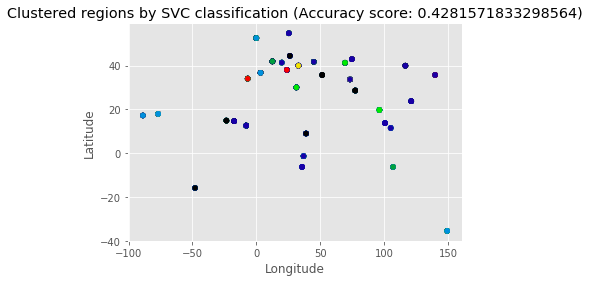

<Figure size 432x288 with 0 Axes>

In [25]:
plt.style.use('ggplot')
label_color = [matplotlib.cm.nipy_spectral(float(l) /n_clusters) for l in best_model['svc'][2]]
plt.scatter(y_coords[:, 1], y_coords[:, 0], c = label_color, s=25)
plt.title("Clustered regions by SVC classification (Accuracy score: %s)" % best_model['svc'][0])
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()

<Figure size 432x288 with 0 Axes>

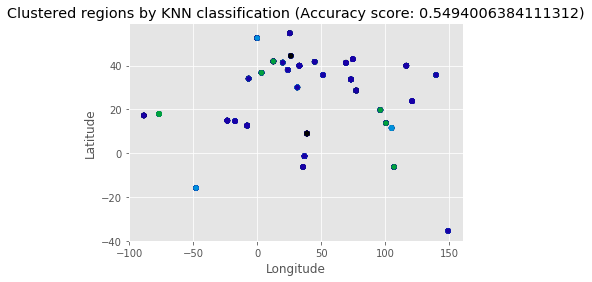

<Figure size 432x288 with 0 Axes>

In [26]:
plt.style.use('ggplot')
label_color = [matplotlib.cm.nipy_spectral(float(l) /n_clusters) for l in best_model['knn'][2]]
plt.scatter(y_coords[:, 1], y_coords[:, 0], c = label_color, s=25)
plt.title("Clustered regions by KNN classification (Accuracy score: %s)" % best_model['knn'][0])
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()

<Figure size 432x288 with 0 Axes>

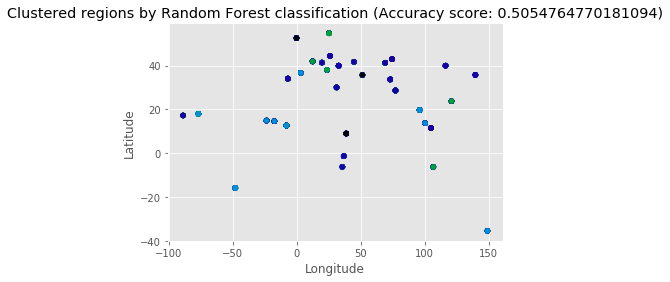

<Figure size 432x288 with 0 Axes>

In [27]:
plt.style.use('ggplot')
label_color = [matplotlib.cm.nipy_spectral(float(l) /n_clusters) for l in best_model['rfc'][2]]
plt.scatter(y_coords[:, 1], y_coords[:, 0], c = label_color, s=25)
plt.title("Clustered regions by Random Forest classification (Accuracy score: %s)" % best_model['rfc'][0])
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()


After applying our the best hyperparameters to each of the three models, we were still not could still not reach 50% accuracy for classifying music by geographic location, even after we reduced the number of cluster to 7.

Random Forest Classification did marginally better than the other two models with an accuracy score of 46.3% when considering 7 geographical clusters.

Geographically the coordinate plot above makes more or less sense. Kmeans have roughly clustered different continents together. There are a few points that might not be in the correct geographic cluster, but it makes sense to cluster as above.

The second plot shows clustering according  to music features. Even though the colours do not seem to be matching the cluster colours on the on the coordinate clustering plot, it would appear as if the second plot is somewhat clustered by geographic location. However, it is difficult to measure this accuracy by only looking at the plot.

In [28]:
# import pandas as pd

results_columns = ['Geo', 'SVC','RFC','KNN'] 
results_index = ['obs_%d'%i for i in range(0,len(best_model['svc'][2]))]

# display format as scientific 
pd.options.display.float_format = '{:,.4g}'.format
results_df = pd.DataFrame(index=results_index, columns=results_columns)
results_df

for i in range(0, len(best_model['svc'][2])):
    results_df.iloc[i, 0] = ytest[i]
    results_df.iloc[i, 1] = best_model['svc'][2][i]
    results_df.iloc[i, 2] = best_model['rfc'][2][i]
    results_df.iloc[i, 3] = best_model['knn'][2][i]
    
correct_columns = ['SVC', 'RFC', 'KNN']
correct_index = ['Correct', 'Incorrect']

pd.options.display.float_format = '{:,.4g}'.format
correct_df = pd.DataFrame(index=correct_index, columns=correct_columns)
correct_df

for i in range(0, 3, 1):
    correct_df.iloc[0, i] = len(results_df[results_df['Geo'] == results_df.iloc[:, i+1]])
    correct_df.iloc[1, i] = len(results_df[results_df['Geo'] != results_df.iloc[:, i+1]])
    
correct_df

,SVC,RFC,KNN
Correct,329,352,334
Incorrect,519,496,514


In [49]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import RidgeClassifier
from sklearn.linear_model import RidgeClassifier
# Create classifiers
seed = 1234
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc]
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, Xtest, ytest, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10,n_jobs=-1)
    
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.493, std: (+/-) 0.034 [RandomForestClassifier]
Mean of: 0.335, std: (+/-) 0.042 [Bagging RandomForestClassifier]

Mean of: 0.482, std: (+/-) 0.045 [ExtraTreesClassifier]
Mean of: 0.351, std: (+/-) 0.045 [Bagging ExtraTreesClassifier]

Mean of: 0.544, std: (+/-) 0.053 [KNeighborsClassifier]
Mean of: 0.317, std: (+/-) 0.052 [Bagging KNeighborsClassifier]

Mean of: 0.508, std: (+/-) 0.037 [SVC]
Mean of: 0.273, std: (+/-) 0.033 [Bagging SVC]



In [56]:
# from sklearn.ensemble import VotingClassifier
# clf = [rf, et, knn]
# eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')
# for clf, label in zip([rf, et, knn, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'Ensemble']):
#     scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.34 (+/- 0.07) [Random Forest]
Accuracy: 0.33 (+/- 0.03) [Extra Trees]
Accuracy: 0.36 (+/- 0.04) [KNeighbors]


TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [63]:
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_decision_regions
# import matplotlib.gridspec as gridspec
# import itertools
# gs = gridspec.GridSpec(3, 3)
# fig = plt.figure(figsize=(14, 12))
# labels = ['Random Forest', 'Extra Trees', 'KNN', 'Support Vector',
#           'Ridge Reg.', 'Ensemble']
# for clf, lab, grd in zip([rf, et, knn, svc, rg, eclf], labels,itertools.product([0, 1, 2], repeat = 2)):
#     clf.fit(X[['lotsize', 'stories']], y)
#     ax = plt.subplot(gs[grd[0], grd[1]])
#     fig = plot_decision_regions(X=np.array(X[['lotsize', 'stories']]), 
#                                 y=np.array(y), clf=clf)
#     plt.title(lab)

/home/nikhil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1008x864 with 0 Axes>

In [75]:
# from itertools import combinations
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# names = ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier']
# def zip_stacked_classifiers(*args):
#     to_zip = []
#     for arg in args:
#         combined_items = sum([map(list, combinations(arg, i))for i in range(len(arg) + 1)], [])
#         combined_items = filter(lambda x: len(x) > 0, combined_items)
#         to_zip.append(combined_items)
    
#     return zip(to_zip[0], to_zip[1])
# stacked_clf_list = zip_stacked_classifiers(clf_array, names)
# best_combination = [0.00, ""]
# for clf in stacked_clf_list:
    
#     ensemble = SuperLearner(scorer = accuracy_score, 
#                             random_state = seed, 
#                             folds = 10)
#     ensemble.add(clf[0])
#     ensemble.add_meta(lr)
#     ensemble.fit(Xtrain, ytrain)
#     preds = ensemble.predict(Xtest)
#     accuracy = accuracy_score(preds, ytest)
    
#     if accuracy > best_combination[0]:
#         best_combination[0] = accuracy
#         best_combination[1] = clf[1]
    
#     print("Accuracy score: {:.3f} {}").format(accuracy, clf[1])
#     print("\nBest stacking model is {} with accuracy of: {:.3f}").format(best_combination[1], best_combination[0])

TypeError: can only concatenate list (not "map") to list

In [92]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, Xtest, ytest, cv=kfold)
print(results.mean())

0.2924229691876751


In [90]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
kfold = model_selection.KFold(n_splits=20,random_state=10)
cart = DecisionTreeClassifier()
num_trees = 200
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=10)
results = model_selection.cross_val_score(model, Xtest, ytest, cv=kfold)
print(results.mean())

0.5376522702104098


In [94]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
kfold = model_selection.KFold(n_splits=19,shuffle = True , random_state=10)
cart = DecisionTreeClassifier()
num_trees = 200
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=10)
results = model_selection.cross_val_score(model, Xtest, ytest, cv=kfold)
print(results.mean())

0.5212918660287083


In [80]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, Xtest, ytest, cv=kfold)
print(results.mean())

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'